In [1]:
import numpy as np
import pandas as pd
import glob, os, sys, time
sys.path.append('/Users/shiyunqiu/')
from utils.misc import getConfigFile, readPickle, displayTime, loadHDF5,getLowestError
from   model_th.dmm import DMM
import model_th.learning as DMM_learn
import model_th.evaluate as DMM_evaluate
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
mpl.rcParams['lines.linewidth']=2.5
mpl.rcParams['lines.markersize']=8
mpl.rcParams['text.usetex']=True
mpl.rcParams['text.latex.unicode']=True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['text.latex.preamble']= ['\usepackage{amsfonts}','\usepackage{amsmath}']
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize']=20
mpl.rcParams['legend.fontsize']=20

/Users/shiyunqiu/miniconda3/envs/myenv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# remove zeros
df = pd.read_csv('/Users/shiyunqiu/AM231_Project/data/bitcoin_price.csv')
df = df[::-1]
df = df.Close.values[175:].reshape(-1,1)
print(df.shape)

(1585, 1)


In [3]:
# split into train and test sets
train_size = 1574
train_all, test_all = df[:train_size, :], df[train_size:, :]
print(len(train_all), len(test_all))

(1574, 11)


In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train_all = scaler.fit_transform(train_all)
test_all = scaler.transform(test_all)

In [5]:
def generate_sample(T, nsample, start_indx, end_indx, df):
    sample = []
    idx = np.random.randint(start_indx, end_indx, nsample, 'int')
    for i, val in enumerate(idx):
        piece = df[val:val+10, :]
        sample.append(piece)
    return np.array(sample), idx

In [8]:
# create dataset to pass into DKF

# size of each set
# train_size = int(len(train_all) * 0.9)
# valid_size = int(len(train_all) * 0.1)

# Train: T=10, 1300 samples
train, train_idx = generate_sample(10, 1300, 0, len(train_all)-10, train_all)

# Valid: T=10, 100 samples
valid, valid_idx = generate_sample(10, 100, 0, len(train_all)-10, train_all)

# # Test: T=10, 10 sample
# test, test_idx = generate_sample(10, 10, 0, len(test_all)-10, test_all)

# Test: T=10, 1 sample
test = np.array([test_all[:10, :]])
test_idx = 0


train_dict = {}
train_dict['tensor'] = train
train_dict['mask'] = np.ones((1300, 10))

valid_dict = {}
valid_dict['tensor'] = valid
valid_dict['mask'] = np.ones((100, 10))

test_dict = {}
test_dict['tensor'] = test
test_dict['mask'] = np.ones((1, 10))

dataset = {}
dataset['dim_observations'] = 1
dataset['data_type'] = 'real'
dataset['train'] = train_dict
dataset['valid'] = valid_dict
dataset['test'] = test_dict

print 'Dimensionality of the observations: ', dataset['dim_observations']
print 'Data type of features:', dataset['data_type']
for dtype in ['train','valid','test']:
    print 'dtype: ',dtype, ' type(dataset[dtype]): ',type(dataset[dtype])
    print [(k,type(dataset[dtype][k]), dataset[dtype][k].shape) for k in dataset[dtype]]
    print '--------\n'

Dimensionality of the observations:  1
Data type of features: real
dtype:  train  type(dataset[dtype]):  <type 'dict'>
[('mask', <type 'numpy.ndarray'>, (1300, 10)), ('tensor', <type 'numpy.ndarray'>, (1300, 10, 1))]
--------

dtype:  valid  type(dataset[dtype]):  <type 'dict'>
[('mask', <type 'numpy.ndarray'>, (100, 10)), ('tensor', <type 'numpy.ndarray'>, (100, 10, 1))]
--------

dtype:  test  type(dataset[dtype]):  <type 'dict'>
[('mask', <type 'numpy.ndarray'>, (1, 10)), ('tensor', <type 'numpy.ndarray'>, (1, 10, 1))]
--------



In [9]:
# load parameter
params = readPickle('default.pkl')[0]
for k in params:
    print k, '\t',params[k]

Read  1  objects
dataset 	mm
epochs 	2000
seed 	1
init_weight 	0.1
dim_stochastic 	100
expt_name 	uid
reg_value 	0.05
reloadFile 	./NOSUCHFILE
reg_spec 	_
dim_hidden 	200
lr 	0.0008
reg_type 	l2
init_scheme 	uniform
optimizer 	adam
use_generative_prior 	approx
maxout_stride 	4
batch_size 	20
savedir 	./chkpt
forget_bias 	-5.0
inference_model 	R
emission_layers 	2
savefreq 	10
rnn_cell 	lstm
rnn_size 	600
paramFile 	./NOSUCHFILE
nonlinearity 	relu
rnn_dropout 	0.1
transition_layers 	2
anneal_rate 	2.0
debug 	False
validate_only 	False
transition_type 	mlp
unique_id 	DMM_lr-0_0008-dh-200-ds-100-nl-relu-bs-20-ep-2000-rs-600-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid
leaky_param 	0.0


In [10]:
# modify parameters
params['data_type'] = dataset['data_type']
params['dim_observations'] = dataset['dim_observations']

#The dataset is small, lets change some of the default parameters and the unique ID
params['dim_stochastic'] = 4
params['dim_hidden']     = 4
params['rnn_size']       = 64
params['epochs']         = 200
params['batch_size']     = 100
params['lr'] = 0.001

params['unique_id'] = params['unique_id'].replace('ds-100','ds-4').replace('dh-200','dh-4').replace('rs-600','rs-64')
params['unique_id'] = params['unique_id'].replace('ep-2000','ep-200').replace('bs-20','bs-200')
params['unique_id'] = params['unique_id'].replace('lr-0_0008','lr-0_001')

#Create a temporary directory to save checkpoints
params['savedir']   = params['savedir']+'-ipython/'
os.system('mkdir -p '+params['savedir'])

#Specify the file where `params` corresponding for this choice of model and data will be saved
pfile= params['savedir']+'/'+params['unique_id']+'-config.pkl'

print 'Checkpoint prefix: ', pfile

Checkpoint prefix:  ./chkpt-ipython//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-config.pkl


In [11]:
# build dmm
dmm  = DMM(params, paramFile = pfile)

	<<Sampling biases for LSTM from exponential distribution>>
	<<Nparameters: 34122>>
	<<WARNING: lr will not differentiated with respect to>>
	<<WARNING: anneal will not differentiated with respect to>>
	<<WARNING: update_ctr will not differentiated with respect to>>
	<<Anneal = 1 in 2.0 param. updates>>
	<<Building with RNN dropout:0.1>>
	<<In _LSTM_RNN_layer with dropout 0.1000>>
	<<Modifying : [q_W_input_0,q_b_input_0,W_lstm_r,b_lstm_r,U_lstm_r,q_W_st,q_b_st,q_W_mu,q_b_mu,q_W_cov,q_b_cov,p_trans_W_0,p_trans_b_0,p_trans_W_1,p_trans_b_1,p_trans_W_mu,p_trans_b_mu,p_trans_W_cov,p_trans_b_cov,p_emis_W_0,p_emis_b_0,p_emis_W_1,p_emis_b_1,p_emis_W_out,p_emis_b_out]>>
<< Reg:(l2) Reg. Val:(0.05) Reg. Spec.:(_)>>
<<<<<< Adding l2 regularization for q_W_input_0 >>>>>>
<<<<<< Adding l2 regularization for q_b_input_0 >>>>>>
<<<<<< Adding l2 regularization for W_lstm_r >>>>>>
<<<<<< Adding l2 regularization for b_lstm_r >>>>>>
<<<<<< Adding l2 regularization for U_lstm_r >>>>>>
<<<<<< Adding l2 re

In [12]:
# parameter estimation
#savef specifies the prefix for the checkpoints - we'll use the same save directory as before 
savef    = os.path.join(params['savedir'],params['unique_id'])
savedata = DMM_learn.learn(dmm, dataset['train'], epoch_start =0 ,
                                epoch_end = params['epochs'],
                                batch_size = params['batch_size'],
                                savefreq   = params['savefreq'],
                                savefile   = savef,
                                dataset_eval=dataset['valid'],
                                shuffle    = True )

	<<Original dim: [3 5 1],[3 5]>>
	<<New dim: [1300   10    1],[1300   10]>>
	<<Bnum: 0, Batch Bound: 0.9648, |w|: 29.2962, |dw|: 1.0000, |w_opt|: 0.0000>>
	<<-veCLL:963.8575, KL:90.8664, anneal:0.0100>>
	<<Bnum: 10, Batch Bound: 0.9866, |w|: 28.8088, |dw|: 1.0000, |w_opt|: 0.6335>>
	<<-veCLL:962.5137, KL:24.0878, anneal:1.0000>>
	<<(Ep 0) Bound: 0.9963 [Took 0.4755 seconds] >>
	<<Saving at epoch 0>>
	<<Saved model (./chkpt-ipython/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP0-params) 
		 opt (./chkpt-ipython/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP0-optParams) weights>>
	<<Original dim: [1300   10    1],[1300   10]>>
	<<New dim: [100  10   1],[100  10]>>
	<<(Evaluate) Validation Bound: 0.9712 [Took 0.0120 seconds]>>
	<<Original dim: [100  10   1],[100  10]>>
	<<New dim: [1300   10    1],[1300   10]>>
	<<Bnum: 0, Batch Bound: 0.9731, |w|: 28.6877, |dw|: 1

	<<Bnum: 10, Batch Bound: -0.1862, |w|: 24.0837, |dw|: 1.0000, |w_opt|: 0.4836>>
	<<-veCLL:-509.5092, KL:323.2937, anneal:1.0000>>
	<<(Ep 21) Bound: -0.2760 [Took 0.4421 seconds] >>
	<<Bnum: 0, Batch Bound: -0.4479, |w|: 24.1371, |dw|: 1.0000, |w_opt|: 0.4465>>
	<<-veCLL:-681.5628, KL:233.6775, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.6373, |w|: 24.3785, |dw|: 1.0000, |w_opt|: 0.4948>>
	<<-veCLL:-982.1198, KL:344.8107, anneal:1.0000>>
	<<(Ep 22) Bound: -0.4883 [Took 0.4517 seconds] >>
	<<Bnum: 0, Batch Bound: -0.5058, |w|: 24.4353, |dw|: 1.0000, |w_opt|: 0.3748>>
	<<-veCLL:-848.3838, KL:342.5605, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.6451, |w|: 24.6065, |dw|: 1.0000, |w_opt|: 0.2906>>
	<<-veCLL:-1179.2148, KL:534.1250, anneal:1.0000>>
	<<(Ep 23) Bound: -0.6160 [Took 0.4618 seconds] >>
	<<Bnum: 0, Batch Bound: -0.6610, |w|: 24.6467, |dw|: 1.0000, |w_opt|: 0.3242>>
	<<-veCLL:-1040.1129, KL:379.0686, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.6115, |w|: 24.7878, |dw|: 1.0000,

	<<Bnum: 10, Batch Bound: -1.4910, |w|: 25.6562, |dw|: 1.0000, |w_opt|: 0.3612>>
	<<-veCLL:-1864.6807, KL:373.7177, anneal:1.0000>>
	<<(Ep 44) Bound: -1.1800 [Took 0.4429 seconds] >>
	<<Bnum: 0, Batch Bound: -0.8272, |w|: 25.6594, |dw|: 1.0000, |w_opt|: 0.2683>>
	<<-veCLL:-1286.9679, KL:459.7319, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.1473, |w|: 25.6929, |dw|: 1.0000, |w_opt|: 0.2753>>
	<<-veCLL:-1654.2099, KL:506.9079, anneal:1.0000>>
	<<(Ep 45) Bound: -1.1594 [Took 0.4487 seconds] >>
	<<Bnum: 0, Batch Bound: -0.6673, |w|: 25.7001, |dw|: 1.0000, |w_opt|: 0.2940>>
	<<-veCLL:-1226.1127, KL:558.8001, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.2019, |w|: 25.6961, |dw|: 1.0000, |w_opt|: 0.2972>>
	<<-veCLL:-1567.4124, KL:365.5290, anneal:1.0000>>
	<<(Ep 46) Bound: -1.1374 [Took 0.4560 seconds] >>
	<<Bnum: 0, Batch Bound: -1.1981, |w|: 25.6929, |dw|: 1.0000, |w_opt|: 0.3193>>
	<<-veCLL:-1592.6745, KL:394.5483, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.2734, |w|: 25.6963, |dw|: 1.0

	<<Bnum: 10, Batch Bound: -1.3424, |w|: 26.0107, |dw|: 1.0000, |w_opt|: 0.4028>>
	<<-veCLL:-1749.3020, KL:406.9286, anneal:1.0000>>
	<<(Ep 67) Bound: -1.3446 [Took 0.4464 seconds] >>
	<<Bnum: 0, Batch Bound: -1.3131, |w|: 26.0132, |dw|: 1.0000, |w_opt|: 0.4299>>
	<<-veCLL:-1732.6024, KL:419.5451, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.3379, |w|: 26.0233, |dw|: 1.0000, |w_opt|: 0.4301>>
	<<-veCLL:-1760.1939, KL:422.2590, anneal:1.0000>>
	<<(Ep 68) Bound: -1.3162 [Took 0.4506 seconds] >>
	<<Bnum: 0, Batch Bound: -1.4610, |w|: 26.0279, |dw|: 1.0000, |w_opt|: 0.4165>>
	<<-veCLL:-1869.6780, KL:408.7185, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: 3.0721, |w|: 26.1287, |dw|: 1.0000, |w_opt|: 0.3967>>
	<<-veCLL:2169.5893, KL:902.5304, anneal:1.0000>>
	<<(Ep 69) Bound: 0.1623 [Took 0.4229 seconds] >>
	<<Bnum: 0, Batch Bound: 3.3844, |w|: 26.1346, |dw|: 1.0000, |w_opt|: 0.4003>>
	<<-veCLL:2494.5647, KL:889.8731, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.0562, |w|: 26.0515, |dw|: 1.0000, 

	<<Bnum: 10, Batch Bound: -1.3470, |w|: 26.2415, |dw|: 1.0000, |w_opt|: 0.4879>>
	<<-veCLL:-1807.6349, KL:460.6087, anneal:1.0000>>
	<<(Ep 90) Bound: -1.4415 [Took 0.4570 seconds] >>
	<<Saving at epoch 90>>
	<<Saved model (./chkpt-ipython/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP90-params) 
		 opt (./chkpt-ipython/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP90-optParams) weights>>
	<<Original dim: [1300   10    1],[1300   10]>>
	<<New dim: [100  10   1],[100  10]>>
	<<(Evaluate) Validation Bound: -1.4377 [Took 0.0108 seconds]>>
	<<Original dim: [100  10   1],[100  10]>>
	<<New dim: [1300   10    1],[1300   10]>>
	<<Bnum: 0, Batch Bound: -1.5193, |w|: 26.2455, |dw|: 1.0000, |w_opt|: 0.5291>>
	<<-veCLL:-1959.7387, KL:440.4573, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.3915, |w|: 26.2632, |dw|: 1.0000, |w_opt|: 0.5232>>
	<<-veCLL:-1836.9022, KL:445.4345, 

	<<Bnum: 10, Batch Bound: -1.4935, |w|: 26.4730, |dw|: 1.0000, |w_opt|: 0.5867>>
	<<-veCLL:-1976.6145, KL:483.1462, anneal:1.0000>>
	<<(Ep 111) Bound: -1.5114 [Took 0.4325 seconds] >>
	<<Bnum: 0, Batch Bound: -1.4553, |w|: 26.4768, |dw|: 1.0000, |w_opt|: 0.5639>>
	<<-veCLL:-1983.9627, KL:528.7028, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.4250, |w|: 26.4773, |dw|: 1.0000, |w_opt|: 0.5596>>
	<<-veCLL:-1898.1241, KL:473.1601, anneal:1.0000>>
	<<(Ep 112) Bound: -1.5129 [Took 0.4487 seconds] >>
	<<Bnum: 0, Batch Bound: -1.7179, |w|: 26.4766, |dw|: 1.0000, |w_opt|: 0.5908>>
	<<-veCLL:-2152.2505, KL:434.3418, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.3160, |w|: 26.4833, |dw|: 1.0000, |w_opt|: 0.5558>>
	<<-veCLL:-1863.6126, KL:547.5998, anneal:1.0000>>
	<<(Ep 113) Bound: -1.5017 [Took 0.4668 seconds] >>
	<<Bnum: 0, Batch Bound: -1.4540, |w|: 26.4818, |dw|: 1.0000, |w_opt|: 0.5628>>
	<<-veCLL:-1940.3770, KL:486.3300, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.5800, |w|: 26.4779, |dw|: 

	<<Bnum: 10, Batch Bound: -1.3601, |w|: 26.5592, |dw|: 1.0000, |w_opt|: 0.6050>>
	<<-veCLL:-1895.3330, KL:535.1991, anneal:1.0000>>
	<<(Ep 134) Bound: -1.2875 [Took 0.4396 seconds] >>
	<<Bnum: 0, Batch Bound: -1.2919, |w|: 26.5602, |dw|: 1.0000, |w_opt|: 0.6785>>
	<<-veCLL:-1826.3108, KL:534.4385, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.3799, |w|: 26.5419, |dw|: 1.0000, |w_opt|: 0.6217>>
	<<-veCLL:-1810.0278, KL:430.1432, anneal:1.0000>>
	<<(Ep 135) Bound: -1.2974 [Took 0.4426 seconds] >>
	<<Bnum: 0, Batch Bound: -1.5475, |w|: 26.5388, |dw|: 1.0000, |w_opt|: 0.6302>>
	<<-veCLL:-1949.5416, KL:402.0905, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.3038, |w|: 26.5629, |dw|: 1.0000, |w_opt|: 0.6070>>
	<<-veCLL:-1869.8565, KL:566.0148, anneal:1.0000>>
	<<(Ep 136) Bound: -1.5245 [Took 0.4478 seconds] >>
	<<Bnum: 0, Batch Bound: -1.4057, |w|: 26.5687, |dw|: 1.0000, |w_opt|: 0.6128>>
	<<-veCLL:-1959.5294, KL:553.7937, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.5781, |w|: 26.5522, |dw|: 

	<<Bnum: 10, Batch Bound: -1.9646, |w|: 26.6788, |dw|: 1.0000, |w_opt|: 0.6490>>
	<<-veCLL:-2321.4058, KL:356.7567, anneal:1.0000>>
	<<(Ep 157) Bound: -1.5640 [Took 0.4539 seconds] >>
	<<Bnum: 0, Batch Bound: -1.6035, |w|: 26.6774, |dw|: 1.0000, |w_opt|: 0.6409>>
	<<-veCLL:-2007.8918, KL:404.3844, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.6427, |w|: 26.6877, |dw|: 1.0000, |w_opt|: 0.6414>>
	<<-veCLL:-2186.8723, KL:544.1246, anneal:1.0000>>
	<<(Ep 158) Bound: -1.6293 [Took 0.4496 seconds] >>
	<<Bnum: 0, Batch Bound: -1.6623, |w|: 26.7064, |dw|: 1.0000, |w_opt|: 0.6459>>
	<<-veCLL:-2108.1739, KL:445.9091, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.7511, |w|: 26.7278, |dw|: 1.0000, |w_opt|: 0.6461>>
	<<-veCLL:-2152.4446, KL:401.3308, anneal:1.0000>>
	<<(Ep 159) Bound: -1.5831 [Took 0.4497 seconds] >>
	<<Bnum: 0, Batch Bound: -0.8523, |w|: 26.7479, |dw|: 1.0000, |w_opt|: 0.6523>>
	<<-veCLL:-1513.5739, KL:661.3177, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.1098, |w|: 26.7547, |dw|: 

	<<Bnum: 10, Batch Bound: -1.5122, |w|: 26.7640, |dw|: 1.0000, |w_opt|: 0.7073>>
	<<-veCLL:-1910.8143, KL:398.6118, anneal:1.0000>>
	<<(Ep 180) Bound: -1.5700 [Took 0.4502 seconds] >>
	<<Saving at epoch 180>>
	<<Saved model (./chkpt-ipython/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP180-params) 
		 opt (./chkpt-ipython/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP180-optParams) weights>>
	<<Original dim: [1300   10    1],[1300   10]>>
	<<New dim: [100  10   1],[100  10]>>
	<<(Evaluate) Validation Bound: -1.5501 [Took 0.0097 seconds]>>
	<<Original dim: [100  10   1],[100  10]>>
	<<New dim: [1300   10    1],[1300   10]>>
	<<Bnum: 0, Batch Bound: -1.5786, |w|: 26.7703, |dw|: 1.0000, |w_opt|: 0.6679>>
	<<-veCLL:-1980.2227, KL:401.6493, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.4124, |w|: 26.7776, |dw|: 1.0000, |w_opt|: 0.7335>>
	<<-veCLL:-1895.8370, KL:483.46

In [11]:
# optimal parameters
# opt_params = np.load('./chkpt-ipython/DMM_lr-0_001-dh-64-ds-32-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP190-optParams.npz')
# for k in opt_params: 
#     print k, opt_params[k].shape

In [13]:
#Lets look at the statistics saved at epoch 190
stats = loadHDF5('./chkpt-ipython/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP190-stats.h5')
print [(k,stats[k].shape) for k in stats.keys()]

[(u'valid_bound', (20, 2)), (u'train_bound', (191, 2))]


Text(0,0.5,'Upper Bound on $-\\log p(x)$')

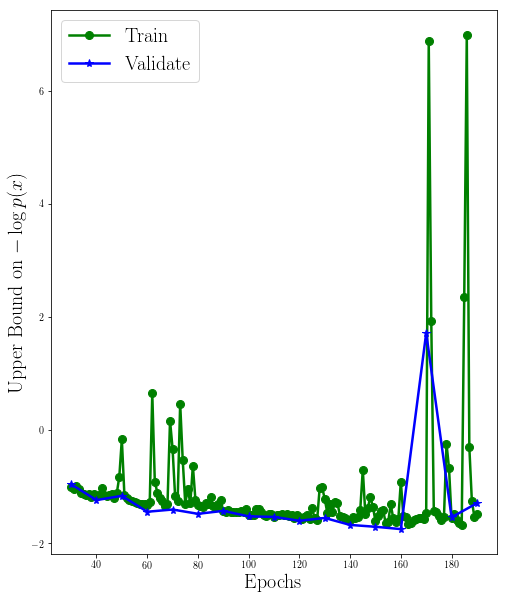

In [14]:
# evaluation
plt.figure(figsize=(8,10))
plt.plot(stats['train_bound'][30:,0],stats['train_bound'][30:,1],'-o',color='g',label='Train')
plt.plot(stats['valid_bound'][3:,0],stats['valid_bound'][3:,1],'-*',color='b',label='Validate')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Upper Bound on $-\log p(x)$')

In [15]:
""" Reload the best DMM based on the validation error """

epochMin, valMin, idxMin = getLowestError(savedata['valid_bound'])
reloadFile= pfile.replace('-config.pkl','')+'-EP'+str(int(epochMin))+'-params.npz'

print 'Loading from : ',reloadFile
params['validate_only']          = True
dmm_best                         = DMM(params, paramFile = pfile, reloadFile = reloadFile)

Loading from :  ./chkpt-ipython//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP160-params.npz
	<<Reloading Model>>
	<<Loading structure (./chkpt-ipython//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-config.pkl) and model (./chkpt-ipython//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP160-params.npz) / opt (./chkpt-ipython//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP160-optParams.npz) weights>>
Adding/Modifying loaded parameters:  validate_only  to  True
	<<Nparameters: 34125>>
	<<Anneal = 1 in 2.0 param. updates>>
	<<Building with RNN dropout:0.0>>


models/__init__.py:201: UserWarning: lr found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")
models/__init__.py:201: UserWarning: anneal found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")
models/__init__.py:201: UserWarning: update_ctr found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")


	<<In _LSTM_RNN_layer with dropout 0.0000>>
	<<Completed DMM setup>>
	<<_buildModel took : 22.8573 seconds>>


In [16]:
test_bound = DMM_evaluate.evaluateBound(dmm_best, dataset['test'], batch_size = params['batch_size'])
print("Test bound", test_bound)
print("Validation bound", stats['valid_bound'][-1,1])
print("Train bound", stats['train_bound'][-1,1])

	<<Original dim: [3 5 1],[3 5]>>
	<<New dim: [ 1 10  1],[ 1 10]>>
	<<(Evaluate) Validation Bound: 2.2336 [Took 0.0043 seconds]>>
('Test bound', 2.233643812977671)
('Validation bound', -1.3018948381085538)
('Train bound', -1.498253606034776)


In [17]:
train_pred =DMM_evaluate.reconstruct(dmm_best, dataset['train'])

In [18]:
valid_pred =DMM_evaluate.reconstruct(dmm_best, dataset['valid'])

In [19]:
test_pred = DMM_evaluate.reconstruct(dmm_best, dataset['test'])

In [20]:
np.array(test_pred).shape

(2, 1, 10, 1)

In [24]:
print(np.array(test_pred))

[[[[ 0.0562954 ]
   [ 0.05673316]
   [ 0.05673316]
   [ 0.05155017]
   [ 0.05669283]
   [ 0.05673316]
   [ 0.05590433]
   [ 0.05673316]
   [ 0.05286722]
   [ 0.04637695]]]


 [[[-0.76519774]
   [-0.66987727]
   [-0.66987727]
   [-1.79978319]
   [-0.67867976]
   [-0.66987727]
   [-0.85078397]
   [-0.66987727]
   [-1.51293868]
   [-2.92743439]]]]


In [23]:
print(test_all[test_idx+9])
print(test_all[test_idx+10])

[0.5718993]
[0.58113192]


In [25]:
np.array(test_pred)[0]

array([[[0.0562954 ],
        [0.05673316],
        [0.05673316],
        [0.05155017],
        [0.05669283],
        [0.05673316],
        [0.05590433],
        [0.05673316],
        [0.05286722],
        [0.04637695]]])

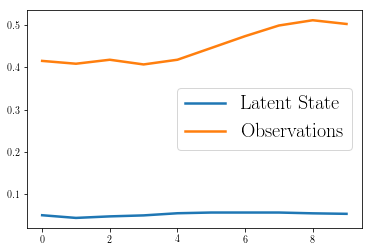

In [26]:
plt.plot(range(10), np.array(train_pred)[:, 0, :, 0][0], label='Latent State')
plt.plot(range(10), train_all[train_idx[0]:train_idx[0]+10], label='Observations')
plt.legend(loc='best')

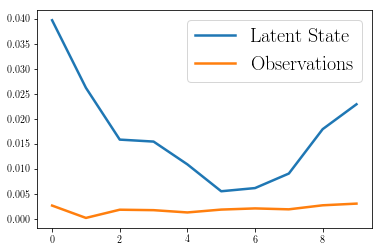

In [27]:
plt.plot(range(10), np.array(valid_pred)[:, 0, :, 0][0], label='Latent State')
plt.plot(range(10), train_all[valid_idx[0]:valid_idx[0]+10], label='Observations')
plt.legend(loc='best')

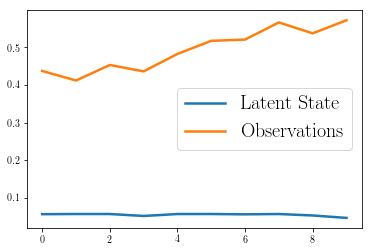

In [28]:
plt.plot(range(10), np.array(test_pred)[:, 0, :, 0][0], label='Latent State')
plt.plot(range(10), test_all[test_idx:test_idx+10], label='Observations')
plt.legend(loc='best')